# Remap MCS mask from non-global lat/lon grid to global HEALPix grid

## Author:
- Zhe Feng || zhe.feng@pnnl.gov

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh

/global/common/software/m1867/python/hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
root_dir = '/pscratch/sd/w/wcmca1/scream-cess-healpix/'

# Zoom level; resolution
s='10' ; dkm='6'
res = ' ('+dkm+'km)'

# Healpix Zarr file directory
in_hp_dir = f"{root_dir}scream2D_hrly_rlut_hp{s}_v6.zarr"
print(in_hp_dir)

# MCS lat/lon mask Zarr file directory
mask_dir = f'{root_dir}mcs_tracking_hp{s}/mcstracking/'
in_mask_dir = f'{mask_dir}mcs_mask_latlon_20190901.0000_20200901.0000.zarr'
print(in_mask_dir)

/pscratch/sd/w/wcmca1/scream-cess-healpix/scream2D_hrly_rlut_hp10_v6.zarr
/pscratch/sd/w/wcmca1/scream-cess-healpix/mcs_tracking_hp10/mcstracking/mcs_mask_latlon_20190901.0000_20200901.0000.zarr


In [3]:
xr.__version__

'2025.3.0'

In [4]:
# Get chunk size from config
chunksize_time = 24
chunksize_cell = "auto"

# Read mask data
mask_chunks = {"time": min(100, chunksize_time), "lat": "auto", "lon": "auto"}

## MCS mask data from PyFLEXTRKR is on a lat/lon grid
- lon: -180° to +180° (actual grid: -179.9° to +179.9° with 0.01° resolution)
- lat: -60° to +60° (actual grid: -59.95° to -59.95° with 0.01° resolution)

In [5]:
# Read mask data
ds_mask = xr.open_dataset(in_mask_dir, engine='zarr', chunks=mask_chunks)
ds_mask

<xarray.Dataset> Size: 301GB
Dimensions:   (lat: 1200, lon: 3600, time: 8713)
Coordinates:
  * lat       (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon       (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
Data variables:
    mcs_mask  (time, lat, lon) float64 301GB dask.array<chunksize=(24, 480, 1200), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Mon Mar 24 12:16:37 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

## Function to modify DataSet lat/lon grid

In [6]:
def prepare_grid_for_analysis(ds, var_name='mcs_mask', lon_dim='lon', lat_dim='lat',
                             target_lat_range=None, lat_spacing=None, fill_value=0):
    """
    Prepares a lat-lon grid dataset for analysis by:
    1. Converting longitude from -180/+180 to 0-360 range and rolling to start at 0
    2. Ensuring latitude is in descending order (+90 to -90)
    3. Expanding latitude range to cover as much of the globe as possible without exceeding ±90°
    
    All operations maintain lazy evaluation for Dask compatibility.
    
    Args:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Input dataset with latitude and longitude dimensions
    var_name : str, optional
        Name of the variable to process (only used if ds is a Dataset), by default 'mcs_mask'
    lon_dim : str, optional
        Name of longitude dimension, by default 'lon'
    lat_dim : str, optional
        Name of latitude dimension, by default 'lat'
    target_lat_range : tuple, optional
        Target (min, max) latitude range. If None, will be inferred from data.
    lat_spacing : float, optional
        Latitude spacing in degrees. If None, will be inferred from data.
    fill_value : int or float, optional
        Value to fill expanded regions with, by default 0
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with longitude in 0-360 range, rolled to start at 0,
        latitude in descending order (+90 to -90), and expanded to target range
    """   
    # Determine if input is DataArray or Dataset
    is_dataarray = isinstance(ds, xr.DataArray)
    
    # Step 1: Handle longitude conversion and rolling
    # Find where longitude crosses from negative to positive
    lon_0_index = (ds[lon_dim] < 0).sum().item()
    
    # Create indexers for the roll
    lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
    
    # Roll dataset and convert longitudes to 0-360 range
    rolled_ds = ds.isel({lon_dim: lon_indices})
    new_lons = xr.where(rolled_ds[lon_dim] < 0, rolled_ds[lon_dim] + 360, rolled_ds[lon_dim])
    rolled_ds = rolled_ds.assign_coords({lon_dim: new_lons})
    
    # Step 2: Handle latitude order and determine expansion needs
    lat_values = rolled_ds[lat_dim].values
    is_descending = np.all(np.diff(lat_values) < 0)
    
    # Flip latitudes if not already in descending order
    if not is_descending:
        lat_indices = np.arange(rolled_ds.sizes[lat_dim] - 1, -1, -1)
        rolled_ds = rolled_ds.isel({lat_dim: lat_indices})
        lat_values = rolled_ds[lat_dim].values
    
    # Infer lat_spacing if not provided
    if lat_spacing is None:
        # Calculate spacing from the first two points
        # Use absolute value to handle both ascending and descending orders
        lat_spacing = abs(lat_values[1] - lat_values[0])
    
    # Infer target_lat_range if not provided
    if target_lat_range is None:
        # Find the highest possible latitude value without exceeding ±90°
        # For a grid with 0.1° spacing, this would be ±89.95°
        max_possible_lat = 90.0 - (lat_spacing / 2)
        min_possible_lat = -max_possible_lat
        target_lat_range = (min_possible_lat, max_possible_lat)
    
    # Get data array and current latitude range
    if is_dataarray:
        data_array = rolled_ds
    else:
        data_array = rolled_ds[var_name]
    
    current_min_lat, current_max_lat = lat_values.min(), lat_values.max()
    target_min, target_max = sorted(target_lat_range)
    
    # Calculate expansion points needed
    south_points = int(round((current_min_lat - target_min) / lat_spacing))
    north_points = int(round((target_max - current_max_lat) / lat_spacing))

    # Step 3: If no expansion needed, return the rolled dataset
    if south_points <= 0 and north_points <= 0:
        return rolled_ds
    
    # Step 4: Create expansion arrays
    dims = data_array.dims
    lat_idx = data_array.dims.index(lat_dim)
    
    # Create new latitude coordinates
    if north_points > 0:
        # Create new northern latitudes from target max to highest current
        # We need to maintain descending order (higher to lower latitude)
        new_north_lats = np.linspace(target_max, current_max_lat + lat_spacing, north_points)
        north_shape = list(data_array.shape)
        north_shape[lat_idx] = north_points
        north_data = da.zeros(north_shape, chunks="auto", dtype=data_array.dtype)
        north_coords = {dim: data_array[dim] for dim in dims if dim != lat_dim}
        north_coords[lat_dim] = new_north_lats
        north_da = xr.DataArray(north_data, dims=dims, coords=north_coords)
    else:
        north_da = None

    if south_points > 0:
        # Create new southern latitudes from lowest current to target min
        # Also in descending order
        new_south_lats = np.linspace(current_min_lat - lat_spacing, target_min, south_points)
        south_shape = list(data_array.shape)
        south_shape[lat_idx] = south_points
        south_data = da.zeros(south_shape, chunks="auto", dtype=data_array.dtype)
        south_coords = {dim: data_array[dim] for dim in dims if dim != lat_dim}
        south_coords[lat_dim] = new_south_lats
        south_da = xr.DataArray(south_data, dims=dims, coords=south_coords)
    else:
        south_da = None

    # Step 5: Concatenate along latitude dimension
    arrays_to_concat = []
    if north_da is not None:
        arrays_to_concat.append(north_da)
    arrays_to_concat.append(data_array)
    if south_da is not None:
        arrays_to_concat.append(south_da)
    
    expanded_da = xr.concat(arrays_to_concat, dim=lat_dim)

    # Step 6: Return result based on input type
    if not is_dataarray:
        # Create a new dataset with the expanded variable and coordinates
        # Start with an empty dataset with the correct coordinates
        coords = {dim: data_array[dim] for dim in dims if dim != lat_dim}
        coords[lat_dim] = expanded_da[lat_dim]  # Use the new expanded latitude
        
        # Create new dataset with the proper dimensions
        expanded_ds = xr.Dataset(coords=coords)
        
        # Copy all variables from the original dataset except the one we're expanding
        for var in rolled_ds.data_vars:
            if var != var_name:
                # For variables that have lat dimension, we need to extend them
                if lat_dim in rolled_ds[var].dims:
                    # Create an expanded array filled with zeros/NaN for this variable
                    var_shape = list(rolled_ds[var].shape)
                    var_lat_idx = rolled_ds[var].dims.index(lat_dim)
                    var_shape[var_lat_idx] = len(expanded_da[lat_dim])
                    fill = np.nan if np.issubdtype(rolled_ds[var].dtype, np.floating) else 0
                    expanded_var = da.zeros(var_shape, chunks="auto", dtype=rolled_ds[var].dtype)
                    if fill != 0:
                        expanded_var = expanded_var * np.nan
                    
                    # Insert the original data in the proper position
                    expanded_var_da = xr.DataArray(expanded_var, dims=rolled_ds[var].dims, coords=coords)
                    
                    # We'll add this variable but handle it separately
                    expanded_ds[var] = expanded_var_da
                else:
                    # Variables without lat dimension can be copied directly
                    expanded_ds[var] = rolled_ds[var]
        
        # Finally add our main expanded variable
        expanded_ds[var_name] = expanded_da
        
        return expanded_ds
    else:
        return expanded_da

## Convert non-global lat/lon mask DataSet to global DataSet
- lon: convert to 0° to 360°
- lat: expand and flip to +90° to -90°
- Maintain lazy evaluation for Dask

In [7]:
%%time
# Modify mask grid for remapping
ds_mask = prepare_grid_for_analysis(ds_mask)
ds_mask

CPU times: user 1.18 s, sys: 96.3 ms, total: 1.28 s
Wall time: 1.29 s


<xarray.Dataset> Size: 452GB
Dimensions:   (time: 8713, lon: 3600, lat: 1800)
Coordinates:
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
  * lon       (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9
  * lat       (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Data variables:
    mcs_mask  (time, lat, lon) float64 452GB dask.array<chunksize=(24, 255, 255), meta=np.ndarray>

In [8]:
%%time
# Read HEALPix zarr file
ds_hp = xr.open_dataset(in_hp_dir)
ds_hp

CPU times: user 18.1 ms, sys: 546 μs, total: 18.7 ms
Wall time: 17.9 ms


<xarray.Dataset> Size: 476GB
Dimensions:  (crs: 0, time: 9457, cell: 12582912)
Coordinates:
  * crs      (crs) float64 0B 
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    rlut     (time, cell) float32 476GB ...
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

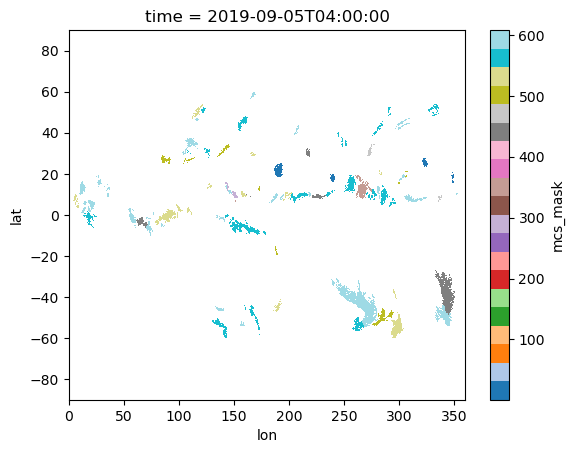

/global/common/software/m1867/python/hackathon/lib/python3.12/site-packages/dask/array/reductions.py:622: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


In [9]:
# Select mask at a specific time slice
mcs_mask = ds_mask.mcs_mask.isel(time=100)

# Expand the latitude range 
# mcs_mask = expand_lat_range(mcs_mask).load()

mcs_mask.where(mcs_mask>0).plot(cmap="tab20")

In [10]:
# Subset the mask dataset for testing
ds_mask_sub = ds_mask.isel(time=slice(100, 110))
ds_mask_sub

<xarray.Dataset> Size: 518MB
Dimensions:   (time: 10, lon: 3600, lat: 1800)
Coordinates:
  * time      (time) datetime64[ns] 80B 2019-09-05T04:00:00 ... 2019-09-05T13...
  * lon       (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9
  * lat       (lat) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Data variables:
    mcs_mask  (time, lat, lon) float64 518MB dask.array<chunksize=(10, 255, 255), meta=np.ndarray>

##  Remap MCS mask to HEALPix grid

Use `healpix.pix2ang` to transform the MCS mask back to the HEALPix grid format

In [11]:
ds_hp.crs.healpix_nside, ds_hp.crs.healpix_order, ds_hp.cell

(1024,
 'nest',
 <xarray.DataArray 'cell' (cell: 12582912)> Size: 101MB
 array([       0,        1,        2, ..., 12582909, 12582910, 12582911])
 Dimensions without coordinates: cell)

In [12]:
%%time
# Make remap lat/lon for HEALPix
remap_lons, remap_lats = hp.pix2ang(
    ds_hp.crs.healpix_nside, ds_hp.cell, nest=ds_hp.crs.healpix_order, lonlat=True,
)
remap_lons = remap_lons % 360
remap_lons.shape, remap_lats.shape

CPU times: user 573 ms, sys: 175 ms, total: 748 ms
Wall time: 747 ms


((12582912,), (12582912,))

In [13]:
remap_lons.min(), remap_lons.max()

(np.float64(0.0), np.float64(359.9560546875))

In [14]:
# Convert to DataArray
lon_hp = xr.DataArray(remap_lons, dims="cell", coords={"cell":ds_hp.cell})
lat_hp = xr.DataArray(remap_lats, dims="cell", coords={"cell":ds_hp.cell})

In [15]:
%%time
# Remap mask to HEALPix
mcs_mask_hp = mcs_mask.sel(
    lon=lon_hp, 
    lat=lat_hp, 
    method="nearest",
)
mcs_mask_hp

CPU times: user 3.04 s, sys: 2.29 s, total: 5.33 s
Wall time: 5.33 s


<xarray.DataArray 'mcs_mask' (cell: 12582912)> Size: 101MB
dask.array<vindex-merge, shape=(12582912,), dtype=float64, chunksize=(102000,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2019-09-05T04:00:00
    lon      (cell) float64 101MB 45.05 45.05 44.95 45.05 ... 315.1 314.9 315.1
    lat      (cell) float64 101MB 0.05 0.05 0.05 0.15 ... -0.05 -0.05 -0.05
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911

In [16]:
%%time
# Remap DataSet to HEALPix
ds_mask_hp = ds_mask_sub.sel(
    lon=lon_hp, 
    lat=lat_hp, 
    method="nearest",
)
ds_mask_hp

CPU times: user 3.12 s, sys: 2.33 s, total: 5.45 s
Wall time: 5.46 s


<xarray.Dataset> Size: 1GB
Dimensions:   (time: 10, cell: 12582912)
Coordinates:
  * time      (time) datetime64[ns] 80B 2019-09-05T04:00:00 ... 2019-09-05T13...
    lon       (cell) float64 101MB 45.05 45.05 44.95 45.05 ... 315.1 314.9 315.1
    lat       (cell) float64 101MB 0.05 0.05 0.05 0.15 ... -0.05 -0.05 -0.05
  * cell      (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
Data variables:
    mcs_mask  (time, cell) float64 1GB dask.array<chunksize=(10, 102000), meta=np.ndarray>

In [17]:
mcs_mask_hp.min().values, mcs_mask_hp.max().values

(array(0.), array(608.))

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS lat/lon')

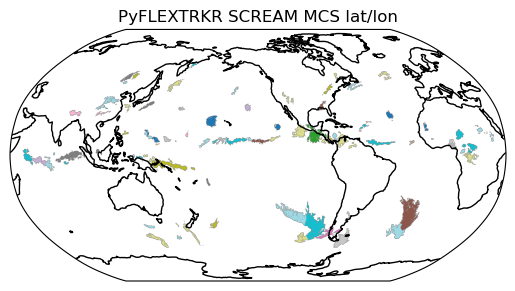

In [18]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ax.imshow(
    mcs_mask.where(mcs_mask!=0), vmin=284, vmax=607, cmap="tab20",
    extent=(0,360,-90,90), transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.title("PyFLEXTRKR SCREAM MCS lat/lon")

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS healpix')

<Figure size 640x480 with 0 Axes>

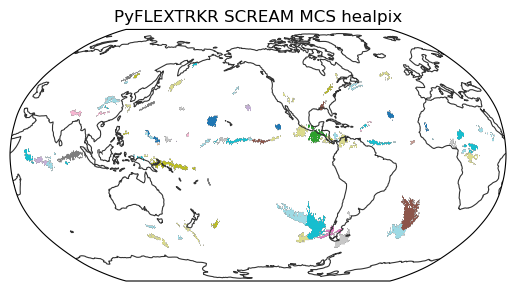

In [19]:
img = egh.healpix_show(mcs_mask_hp.where(mcs_mask_hp!=0), vmin=284, vmax=607, cmap="tab20")
plt.title("PyFLEXTRKR SCREAM MCS healpix")